<a href="https://colab.research.google.com/github/anupojuharshita/Lane-Detection/blob/main/cnn%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Unzipped /content/combined_dataset.zip to /content/combined_dataset
Epoch 1, Loss: 78.0404
Epoch 2, Loss: 73.5269
Epoch 3, Loss: 72.5248
Epoch 4, Loss: 71.9242
Epoch 5, Loss: 71.5775
Epoch 6, Loss: 71.3546
Epoch 7, Loss: 71.0989
Epoch 8, Loss: 70.9597
Epoch 9, Loss: 70.7913
Epoch 10, Loss: 70.7268
Epoch 11, Loss: 70.5561
Epoch 12, Loss: 70.5105
Epoch 13, Loss: 70.3763
Epoch 14, Loss: 70.3612
Epoch 15, Loss: 70.2491
Epoch 16, Loss: 70.1658
Epoch 17, Loss: 70.1316
Epoch 18, Loss: 70.0351
Epoch 19, Loss: 69.9461
Epoch 20, Loss: 69.9509
Epoch 21, Loss: 69.8416
Epoch 22, Loss: 69.8330
Epoch 23, Loss: 69.7934
Epoch 24, Loss: 69.7088
Epoch 25, Loss: 69.6039
Epoch 26, Loss: 69.5678
Epoch 27, Loss: 69.5445
Epoch 28, Loss: 69.5488
Epoch 29, Loss: 69.5212
Epoch 30, Loss: 69.4630
Epoch 31, Loss: 69.4711
Epoch 32, Loss: 69.3848
Epoch 33, Loss: 69.3393
Epoch 34, Loss: 69.2647
Epoch 35, Loss: 69.2546
Epoch 36, Loss: 69.2713
Epoch 37, Loss: 69.2244
Epoch 38, Loss: 69.1862
Epoch 39, Loss: 69.2385
Epo

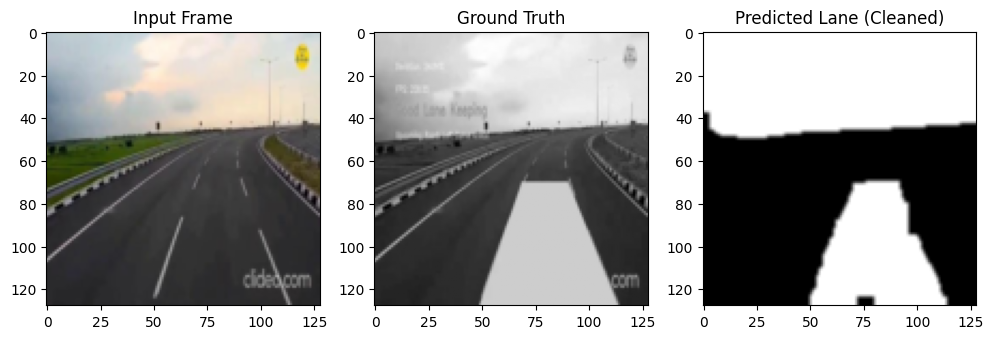

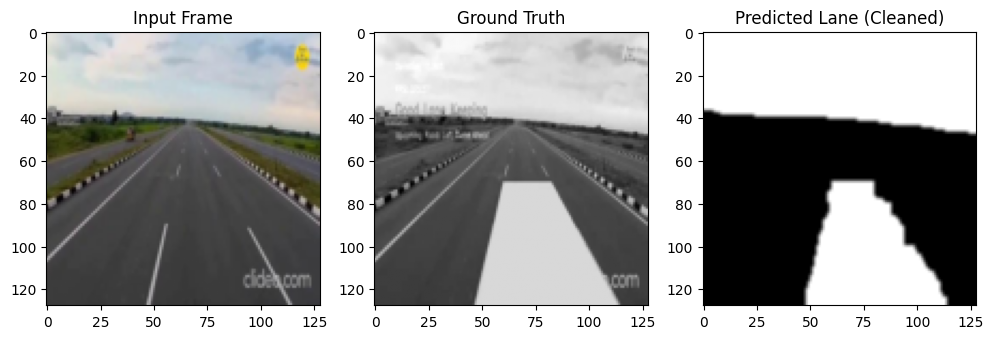

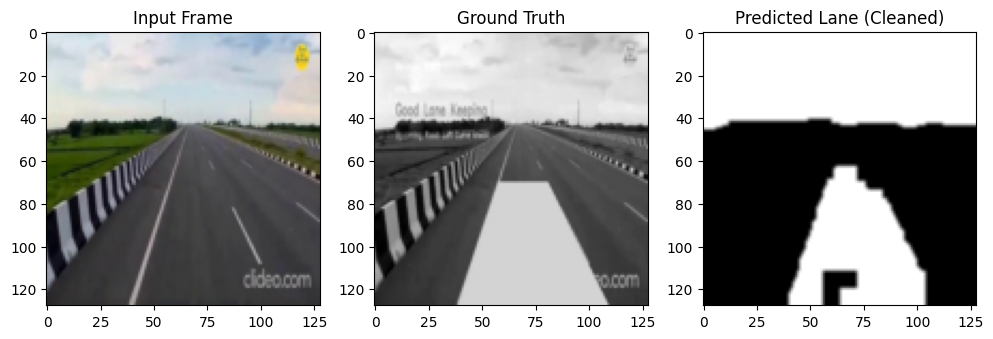

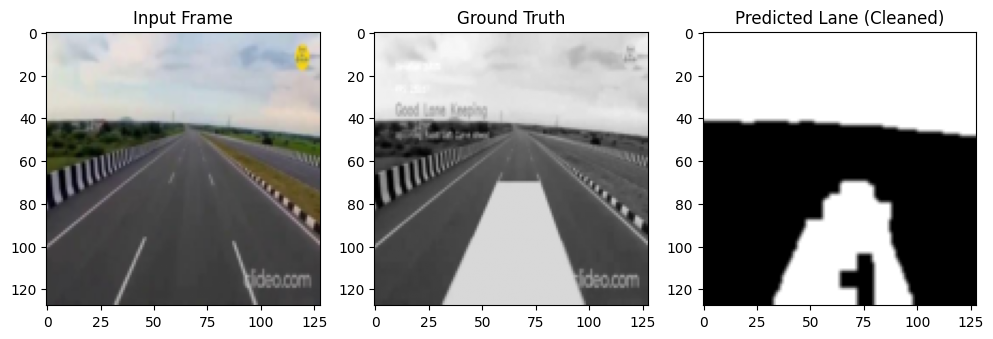

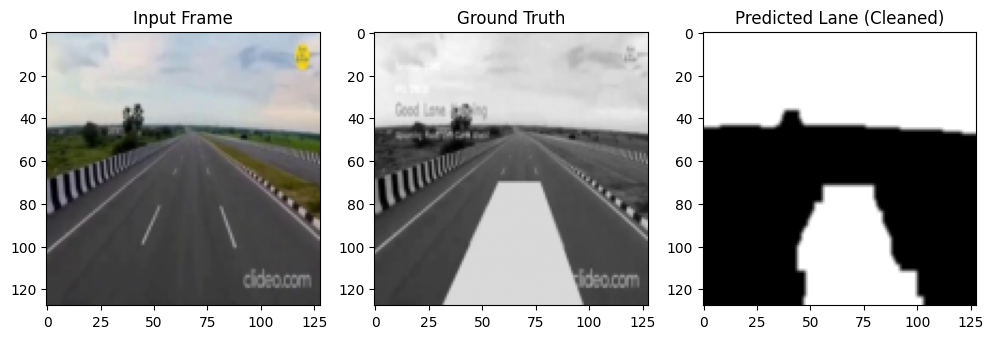

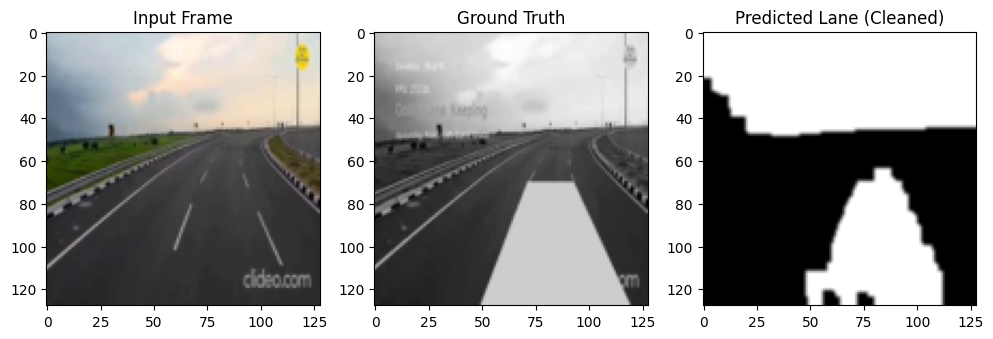

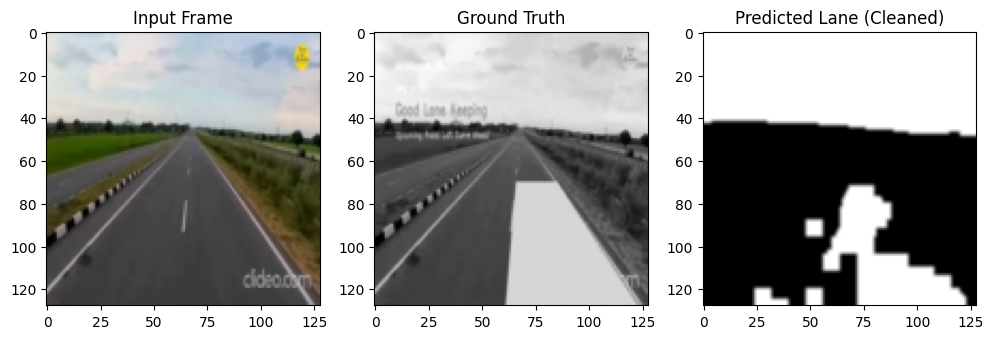

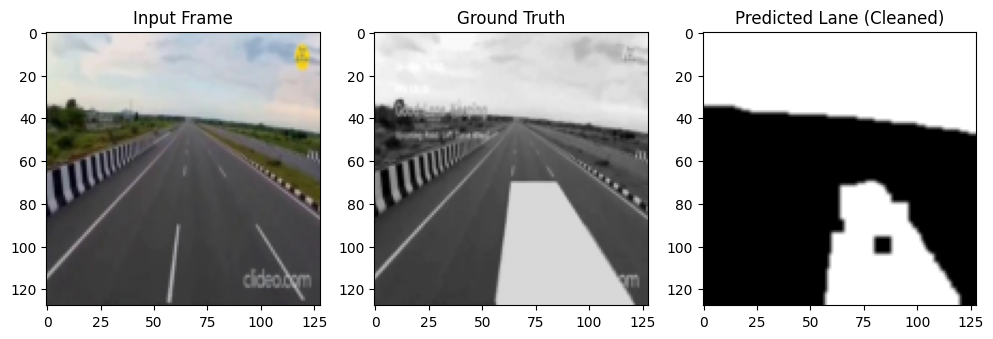

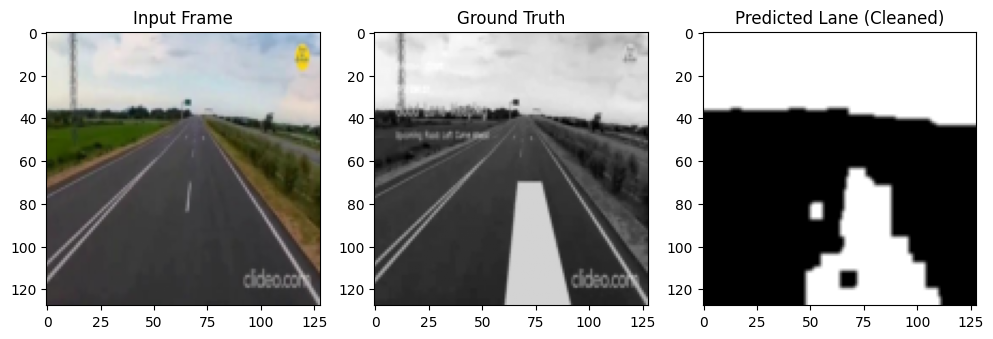

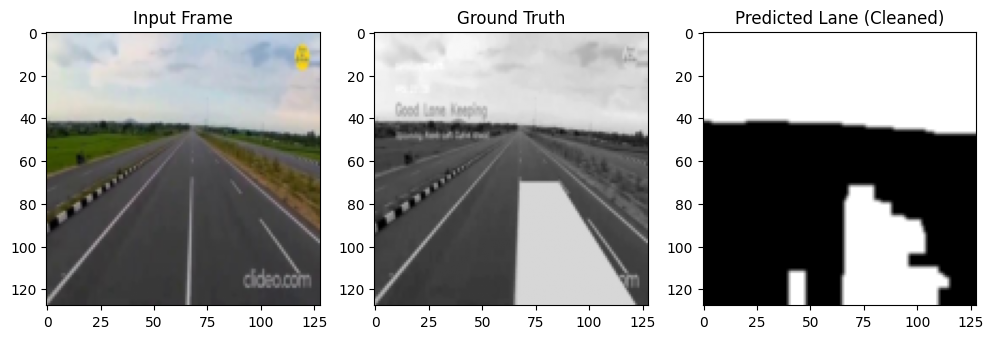

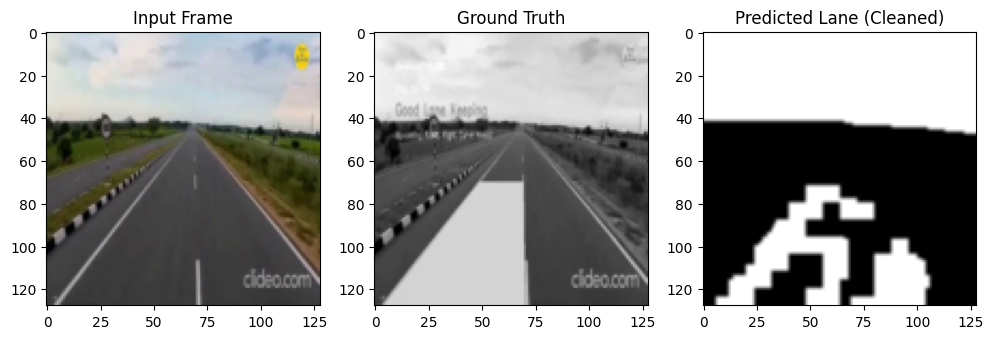

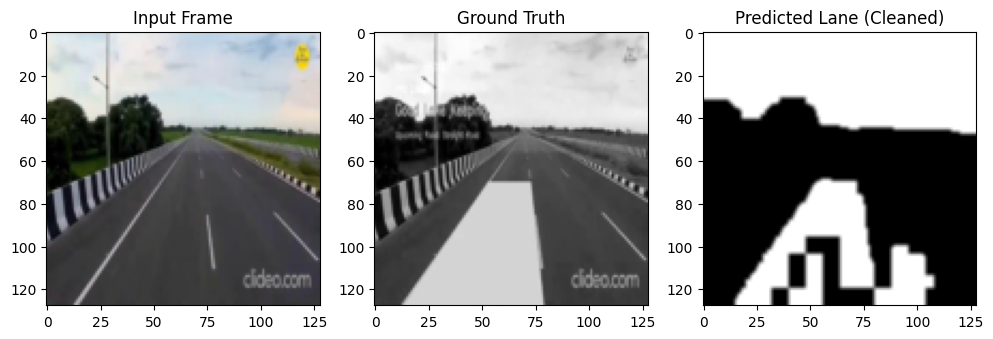

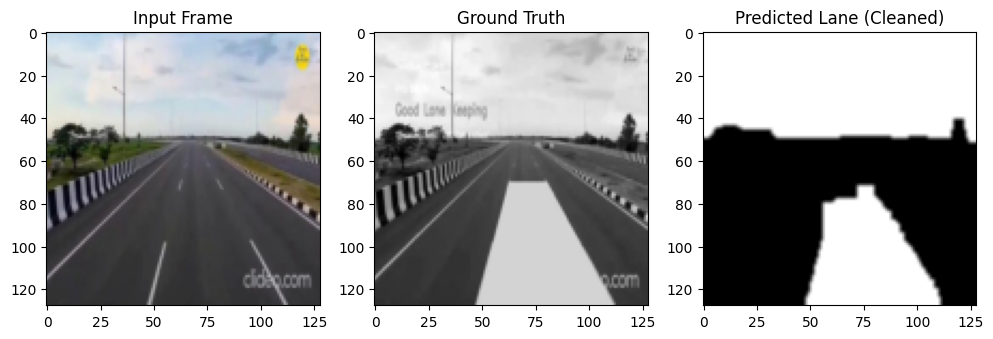

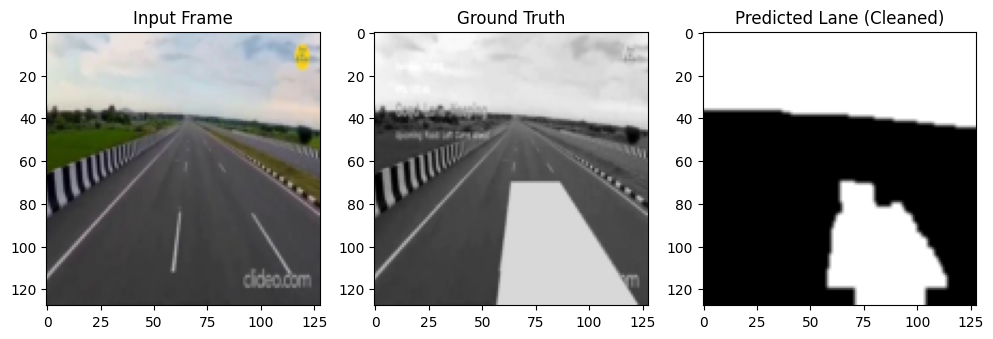

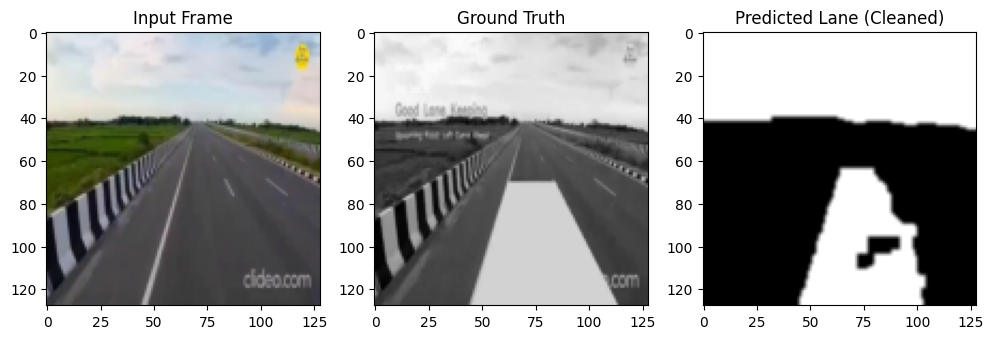

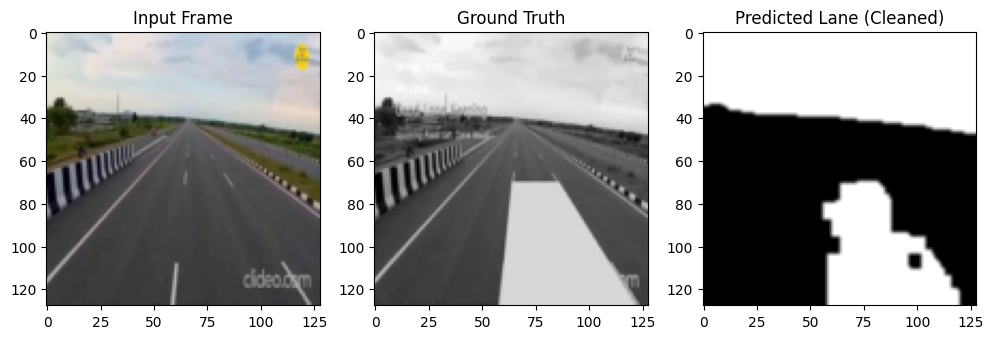

In [2]:
# -----------------------------
# Complete Code with Noise Reduction and Clear Visualization
# -----------------------------
import zipfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# -----------------------------
# 1. Unzip Combined Dataset
# -----------------------------
zip_path = "/content/combined_dataset.zip"
extract_path = "/content/combined_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Unzipped {zip_path} to {extract_path}")

# -----------------------------
# 2. Custom Dataset for Combined Images
# -----------------------------
class CombinedLaneDataset(Dataset):
    def __init__(self, combined_dir):
        self.combined_dir = combined_dir
        self.frame_names = sorted(os.listdir(combined_dir))

        self.input_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.output_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.frame_names)

    def __getitem__(self, idx):
        combined_path = os.path.join(self.combined_dir, self.frame_names[idx])
        combined_image = Image.open(combined_path).convert('RGB')

        w, h = combined_image.size
        input_image = combined_image.crop((0, 0, w // 2, h))
        output_image = combined_image.crop((w // 2, 0, w, h)).convert('L')

        input_tensor = self.input_transform(input_image)
        output_tensor = self.output_transform(output_image)

        # Ensure the mask has only 1 channel
        if output_tensor.shape[0] != 1:
            output_tensor = output_tensor[0].unsqueeze(0)

        return input_tensor, output_tensor

# -----------------------------
# 3. Simple CNN Model for Lane Detection
# -----------------------------
class LaneCNN(nn.Module):
    def __init__(self):
        super(LaneCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# -----------------------------
# 4. Data Preparation
# -----------------------------
dataset = CombinedLaneDataset(extract_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# -----------------------------
# 5. Model Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneCNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 6. Training Loop
# -----------------------------
for epoch in range(50):  # Increase to 20 epochs
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# -----------------------------
# 7. IoU Accuracy Calculation
# -----------------------------
def compute_iou(preds, targets, threshold=0.5):
    preds = preds > threshold
    targets = targets > 0.5
    intersection = (preds & targets).sum().item()
    union = (preds | targets).sum().item()
    return intersection / union if union != 0 else 1.0

total_iou = 0
model.eval()

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        total_iou += compute_iou(preds.cpu() > 0.5, targets.cpu() > 0.5)

print(f"Mean IoU Accuracy: {total_iou / len(train_loader):.4f}")

# -----------------------------
# 8. Visualization with Noise Removal
# -----------------------------
model.eval()
inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)

with torch.no_grad():
    preds = model(inputs).cpu()

for i in range(len(inputs)):
    input_img = np.transpose(inputs[i].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5  # Unnormalize to 0-1
    target_img = targets[i].cpu().squeeze().numpy()
    pred_img = preds[i].squeeze().numpy()

    # Threshold prediction
    pred_mask = (pred_img > 0.5).astype(np.uint8) * 255

    # Morphological operations to reduce noise
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    # Smooth sharp edges (optional)
    cleaned_mask = cv2.GaussianBlur(cleaned_mask, (3, 3), 0)

    # Normalize for display
    cleaned_mask = cleaned_mask / 255.0

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(input_img)
    axs[0].set_title("Input Frame")
    axs[1].imshow(target_img, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(cleaned_mask, cmap='gray')
    axs[2].set_title("Predicted Lane (Cleaned)")

    plt.show()


In [6]:
import os

combined_dir = "/content/combined_dataset"
all_files = os.listdir(combined_dir)

print(f"🔍 Found {len(all_files)} files in the dataset folder.")
print("📂 Example filenames:")
print(all_files[:10])  # Show first 10 files


🔍 Found 2000 files in the dataset folder.
📂 Example filenames:
['frame_0522.jpg', 'frame_1782.jpg', 'frame_0043.jpg', 'frame_0607.jpg', 'frame_0138.jpg', 'frame_1580.jpg', 'frame_1325.jpg', 'frame_0037.jpg', 'frame_1242.jpg', 'frame_1347.jpg']


In [7]:
import os
import cv2
import numpy as np

combined_dir = "/content/combined_dataset"
all_files = sorted(os.listdir(combined_dir))  # Ensure frame_0001.jpg → frame_2000.jpg order

total = len(all_files)
num_frames = total // 2  # Since you only have input + output

input_files = all_files[:num_frames]
gt_files = all_files[num_frames: 2 * num_frames]

input_images = []
gt_masks = []

# Load input and GT
for in_file, gt_file in zip(input_files, gt_files):
    input_img = cv2.imread(os.path.join(combined_dir, in_file))  # color
    gt_img = cv2.imread(os.path.join(combined_dir, gt_file), cv2.IMREAD_GRAYSCALE)  # mask

    input_images.append(input_img)
    gt_masks.append(gt_img)

print(f"✅ Loaded {len(input_images)} input images")
print(f"✅ Loaded {len(gt_masks)} ground truth masks")


✅ Loaded 1000 input images
✅ Loaded 1000 ground truth masks


In [8]:
model.eval()  # Set model to evaluation mode


LaneCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [9]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# ⚠️ Update input size based on what your model expects
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 256)),  # Change to your model's input size
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Use if your model was trained this way
])

def preprocess_image(img):
    return transform(img)

pred_masks = []

for img in input_images:
    input_tensor = preprocess_image(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)  # Add only if model doesn't already include sigmoid
        pred = (pred > 0.5).float()

    pred_np = pred.squeeze().cpu().numpy()  # Shape: (H, W) or (1, H, W)

    if len(pred_np.shape) > 2:
        pred_np = pred_np[0]  # Take first channel if necessary

    # Resize to match GT shape
    pred_np = cv2.resize(pred_np, (img.shape[1], img.shape[0]))
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to binary mask format

    pred_masks.append(pred_np)

print(f"✅ Predicted {len(pred_masks)} lane masks.")


✅ Predicted 1000 lane masks.


In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def evaluate_metrics(pred_mask, true_mask):
    pred_flat = (pred_mask > 127).astype(np.uint8).flatten()
    true_flat = (true_mask > 127).astype(np.uint8).flatten()

    cm = confusion_matrix(true_flat, pred_flat, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    precision = precision_score(true_flat, pred_flat, zero_division=0)
    recall = recall_score(true_flat, pred_flat, zero_division=0)

    return cm, precision, recall


In [11]:
total_cm = np.array([[0, 0], [0, 0]])
all_precisions = []
all_recalls = []

for pred, gt in zip(pred_masks, gt_masks):
    cm, precision, recall = evaluate_metrics(pred, gt)
    total_cm += cm
    all_precisions.append(precision)
    all_recalls.append(recall)

print("\n🔚 Final Evaluation:")
print("Total Confusion Matrix:")
print(total_cm)
print(f"Average Precision: {np.mean(all_precisions):.4f}")
print(f"Average Recall: {np.mean(all_recalls):.4f}")



🔚 Final Evaluation:
Total Confusion Matrix:
[[        0 246532910]
 [        0 214267090]]
Average Precision: 0.4650
Average Recall: 1.0000
